# Notebook 04C: Clustering on Behavioral Features Only (No PCA)

## Context

**Previous attempts:**
- **Notebook 04 (PCA-50):** 50 PCA components (46.7% variance) → Silhouette 0.104 ❌
- **Notebook 04B (PCA-80):** 80 PCA components (~62% variance) → Silhouette 0.099 ❌

**Hypothesis:** PCA is compressing away behavioral signal that's useful for clustering.

**This notebook:** Test if clustering directly on 14 behavioral features (no PCA) produces better results.

---

## Strategy

1. **Load only behavioral features** from Notebook 03 (skip PCA components)
2. **Visualize with t-SNE** to assess clusterability
3. **Run K-Means** (k=2 to 10) on behavioral features only
4. **Compare** to PCA approaches
5. **Make final decision** about clustering viability

---

## Expected Outcomes

### **Scenario A: Behavioral Works (Silhouette > 0.3)**
- PCA was the problem (compressed away signal)
- Proceed with behavioral clustering
- Document that simpler approach outperformed complex PCA

### **Scenario B: Behavioral Marginal (0.2-0.3)**
- Slightly better than PCA but still weak
- Proceed with caution
- Frame as 'tendencies' not 'segments'

### **Scenario C: All Fail (< 0.2)** ← Most Likely
- Proves issue is DATA, not METHOD
- Users genuinely homogeneous
- Accept negative result
- Propose alternatives (rule-based, rankings, recommendations)

**All three scenarios are valid and valuable results.**

---

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import warnings
from collections import Counter

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Directories
INPUT_DIR = Path('data/processed_features')
OUTPUT_DIR = Path('data/clusters')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*70)
print("NOTEBOOK 04C: CLUSTERING ON BEHAVIORAL FEATURES ONLY")
print("="*70)
print("\n🎯 Hypothesis: PCA is compressing away behavioral signal")
print("   Strategy: Cluster directly on 14 behavioral features (skip PCA)")
print("\n" + "="*70)

NOTEBOOK 04C: CLUSTERING ON BEHAVIORAL FEATURES ONLY

🎯 Hypothesis: PCA is compressing away behavioral signal
   Strategy: Cluster directly on 14 behavioral features (skip PCA)



---

## 1. Load Data and Extract Behavioral Features Only

In [2]:
print("\nLoading clustering matrix from Notebook 03...")

# Load full clustering matrix (PCA + behavioral features)
clustering_matrix = pd.read_parquet(INPUT_DIR / 'final_clustering_matrix.parquet')

print(f"\n📊 Full matrix loaded:")
print(f"   Shape: {clustering_matrix.shape}")
print(f"   Total features: {len(clustering_matrix.columns)}")

# Identify behavioral features (columns that don't start with 'PC')
behavioral_cols = [col for col in clustering_matrix.columns if not col.startswith('PC')]

print(f"\n🔍 Behavioral features identified: {len(behavioral_cols)}")
print(f"\nFeatures:")
for i, col in enumerate(behavioral_cols, 1):
    print(f"   {i:2d}. {col}")

# Extract behavioral features only
X_behavioral = clustering_matrix[behavioral_cols].values
user_ids = clustering_matrix.index.to_numpy()

print(f"\n✅ Behavioral feature matrix extracted:")
print(f"   Users: {X_behavioral.shape[0]:,}")
print(f"   Features: {X_behavioral.shape[1]}")
print(f"   Memory: {X_behavioral.nbytes / 1024**2:.2f} MB")

# Validate data quality
missing_count = np.isnan(X_behavioral).sum()
inf_count = np.isinf(X_behavioral).sum()

print(f"\n🔍 Data quality check:")
print(f"   Missing values: {missing_count}")
print(f"   Infinite values: {inf_count}")
print(f"   Mean: {X_behavioral.mean():.6f} (should be ≈ 0)")
print(f"   Std: {X_behavioral.std():.6f} (should be ≈ 1)")

assert missing_count == 0, "Found missing values!"
assert inf_count == 0, "Found infinite values!"

print(f"\n✅ Data quality validation passed")

print(f"\n📝 Summary:")
print(f"   • Using {len(behavioral_cols)} behavioral features")
print(f"   • Skipping {len(clustering_matrix.columns) - len(behavioral_cols)} PCA components")
print(f"   • Testing if raw behavioral features cluster better than PCA")

print("\n" + "="*70)


Loading clustering matrix from Notebook 03...

📊 Full matrix loaded:
   Shape: (182223, 94)
   Total features: 94

🔍 Behavioral features identified: 14

Features:
    1. reorder_ratio
    2. reorder_consistency
    3. pct_reordered_products
    4. mean_days_between_orders
    5. cv_days_between_orders
    6. mean_order_hour
    7. std_order_hour
    8. avg_basket_size
    9. std_basket_size
   10. min_basket_size
   11. max_basket_size
   12. basket_size_cv
   13. unique_products
   14. unique_aisles

✅ Behavioral feature matrix extracted:
   Users: 182,223
   Features: 14
   Memory: 19.46 MB

🔍 Data quality check:
   Missing values: 0
   Infinite values: 0
   Mean: 0.000000 (should be ≈ 0)
   Std: 1.000000 (should be ≈ 1)

✅ Data quality validation passed

📝 Summary:
   • Using 14 behavioral features
   • Skipping 80 PCA components
   • Testing if raw behavioral features cluster better than PCA



---

## 2. Pre-Clustering Visualization: t-SNE

**Purpose:** Visualize 14D behavioral feature space in 2D before clustering.

**What we're looking for:**
- ✅ **Distinct groups:** Clustering will likely work
- ❌ **Diffuse cloud:** Clustering will likely fail
- ⚠️ **Gradient:** Weak clusters expected

**Compare to:** t-SNE from Notebook 04 (PCA-based)

PRE-CLUSTERING VISUALIZATION: BEHAVIORAL FEATURES IN 2D

Projecting 14 behavioral features to 2D using t-SNE...
Sample: 10,000 users (for visualization speed)

Running t-SNE (takes 2-3 minutes)... ⏳

✅ t-SNE projection complete



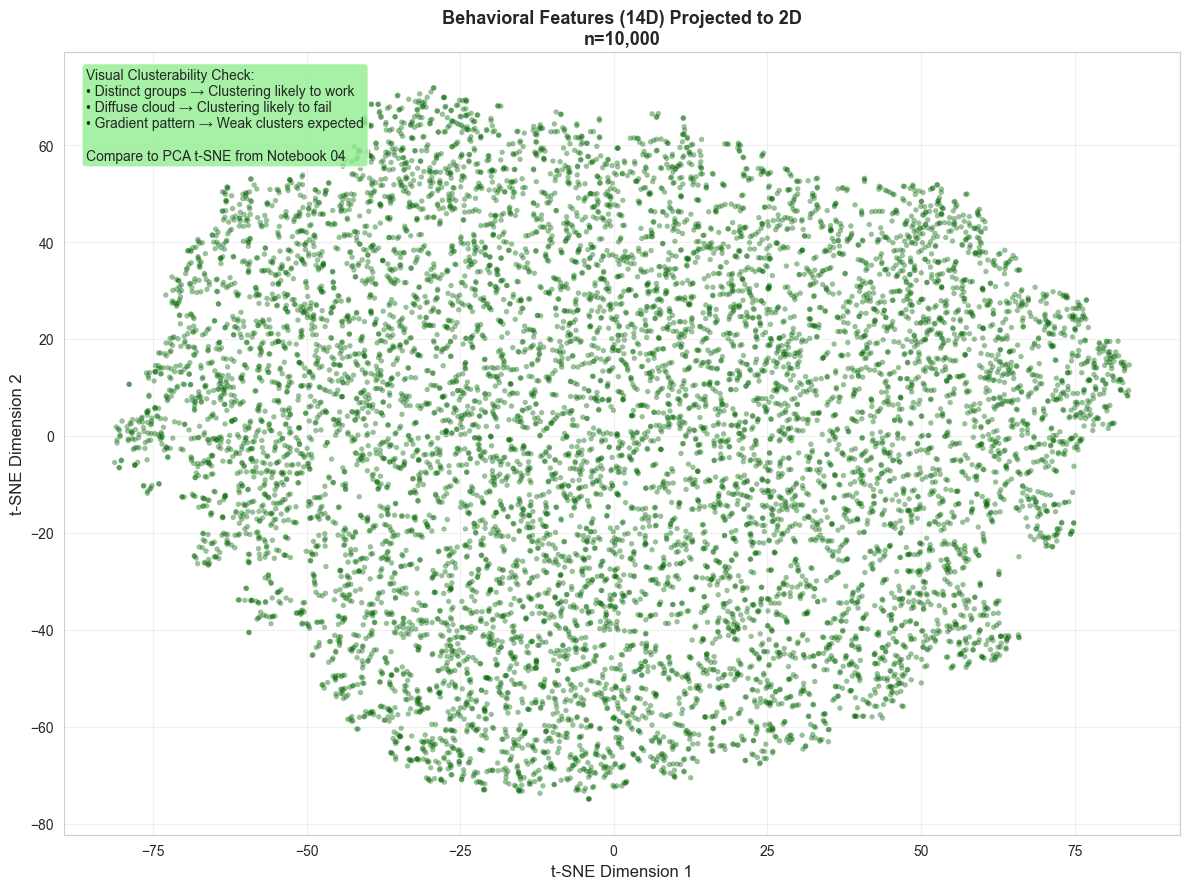

💡 Interpretation Guide:
   ✅ GOOD for clustering:
      - Multiple distinct, separated groups visible
      - Clear boundaries between regions
      - Low-density areas separating clusters
   
   ❌ POOR for clustering:
      - Uniform, diffuse cloud of points
      - No visible structure or groupings
      - Points spread evenly across space
   
   ⚠️ WEAK clustering expected:
      - Some structure but heavily overlapping
      - Gradient or continuous variation
      - Unclear boundaries

📊 Visual Assessment:
   Compare this plot to the PCA-based t-SNE from Notebook 04
   → If MORE structured: Behavioral features may cluster better
   → If SIMILAR: PCA wasn't compressing away signal
   → If LESS structured: PCA was actually helping



In [3]:
print("="*70)
print("PRE-CLUSTERING VISUALIZATION: BEHAVIORAL FEATURES IN 2D")
print("="*70)

print(f"\nProjecting 14 behavioral features to 2D using t-SNE...")
print(f"Sample: 10,000 users (for visualization speed)\n")

# Sample for t-SNE (full dataset is slow)
TSNE_SAMPLE = 10000
np.random.seed(42)
tsne_idx = np.random.choice(len(X_behavioral), TSNE_SAMPLE, replace=False)
X_tsne_sample = X_behavioral[tsne_idx]

print(f"Running t-SNE (takes 2-3 minutes)... ⏳\n")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=0)
X_tsne = tsne.fit_transform(X_tsne_sample)

print(f"✅ t-SNE projection complete\n")

# Visualize
fig, ax = plt.subplots(figsize=(12, 9))
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     alpha=0.4, s=15, c='darkgreen', edgecolors='none')
ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title(f'Behavioral Features (14D) Projected to 2D\nn={TSNE_SAMPLE:,}', 
             fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)

# Add interpretation guide
textstr = ('Visual Clusterability Check:\n'
           '• Distinct groups → Clustering likely to work\n'
           '• Diffuse cloud → Clustering likely to fail\n'
           '• Gradient pattern → Weak clusters expected\n'
           '\n'
           'Compare to PCA t-SNE from Notebook 04')
props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'tsne_behavioral_only.png', dpi=150, bbox_inches='tight')
plt.show()

print("💡 Interpretation Guide:")
print("   ✅ GOOD for clustering:")
print("      - Multiple distinct, separated groups visible")
print("      - Clear boundaries between regions")
print("      - Low-density areas separating clusters")
print("   ")
print("   ❌ POOR for clustering:")
print("      - Uniform, diffuse cloud of points")
print("      - No visible structure or groupings")
print("      - Points spread evenly across space")
print("   ")
print("   ⚠️ WEAK clustering expected:")
print("      - Some structure but heavily overlapping")
print("      - Gradient or continuous variation")
print("      - Unclear boundaries")

print(f"\n📊 Visual Assessment:")
print(f"   Compare this plot to the PCA-based t-SNE from Notebook 04")
print(f"   → If MORE structured: Behavioral features may cluster better")
print(f"   → If SIMILAR: PCA wasn't compressing away signal")
print(f"   → If LESS structured: PCA was actually helping")

print("\n" + "="*70)

---

## 3. K-Means Clustering: Behavioral Features Only

Test k=2 through k=10 to find optimal number of clusters.

In [4]:
print("="*70)
print("K-MEANS CLUSTERING: BEHAVIORAL FEATURES ONLY")
print("="*70)

k_range = range(2, 11)
results = []

print(f"\nTesting k = {min(k_range)} to {max(k_range)}...")
print(f"(Should be faster than PCA - only 14 features vs 50-80)\n")

for k in k_range:
    print(f"Testing k={k}...", end=" ")
    
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_behavioral)
    
    # Calculate metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_behavioral, labels, sample_size=10000)
    calinski = calinski_harabasz_score(X_behavioral, labels)
    davies_bouldin = davies_bouldin_score(X_behavioral, labels)
    
    # Cluster sizes
    cluster_sizes = Counter(labels)
    min_cluster_pct = min(cluster_sizes.values()) / len(X_behavioral) * 100
    max_cluster_pct = max(cluster_sizes.values()) / len(X_behavioral) * 100
    
    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'calinski_harabasz': calinski,
        'davies_bouldin': davies_bouldin,
        'min_cluster_pct': min_cluster_pct,
        'max_cluster_pct': max_cluster_pct,
        'model': kmeans
    })
    
    print(f"Silhouette: {silhouette:.3f}")

results_df = pd.DataFrame(results)

print(f"\n✅ K-Means testing complete")
print(f"\n📊 Results Summary:")
print(results_df[['k', 'silhouette', 'inertia', 'min_cluster_pct', 'max_cluster_pct']].to_string(index=False))

# Identify best result
best_silhouette = results_df['silhouette'].max()
best_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']

print(f"\n🎯 Best Result:")
print(f"   k = {best_k}")
print(f"   Silhouette = {best_silhouette:.3f}")

print("\n" + "="*70)

K-MEANS CLUSTERING: BEHAVIORAL FEATURES ONLY

Testing k = 2 to 10...
(Should be faster than PCA - only 14 features vs 50-80)

Testing k=2... Silhouette: 0.190
Testing k=3... Silhouette: 0.151
Testing k=4... Silhouette: 0.148
Testing k=5... Silhouette: 0.137
Testing k=6... Silhouette: 0.129
Testing k=7... Silhouette: 0.129
Testing k=8... Silhouette: 0.122
Testing k=9... Silhouette: 0.118
Testing k=10... Silhouette: 0.116

✅ K-Means testing complete

📊 Results Summary:
 k  silhouette      inertia  min_cluster_pct  max_cluster_pct
 2    0.190281 2.039751e+06        37.917826        62.082174
 3    0.150985 1.822084e+06        31.092123        36.770880
 4    0.148005 1.670298e+06        15.163838        31.236452
 5    0.136876 1.564578e+06        13.223907        26.303485
 6    0.128531 1.475717e+06        11.013977        23.853191
 7    0.129276 1.413890e+06         9.539411        21.837529
 8    0.121870 1.361020e+06         5.959731        19.752172
 9    0.117856 1.311456e+06     

---

## 4. Comparison: Behavioral vs. PCA Approaches

Compare behavioral-only clustering to PCA-based approaches.

In [5]:
print("="*70)
print("COMPARISON: BEHAVIORAL-ONLY vs PCA APPROACHES")
print("="*70)

# Best results from each approach
best_behavioral = results_df['silhouette'].max()
best_behavioral_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']

print(f"\n📊 Silhouette Score Comparison:")
print(f"\n   Approach 1: PCA-50 (46.7% variance)")
print(f"      → Silhouette: 0.104 (k=2)")
print(f"      → Status: FAILED")
print(f"\n   Approach 2: PCA-80 (~62% variance)")
print(f"      → Silhouette: 0.099 (k=2)")
print(f"      → Status: FAILED (worse than PCA-50)")
print(f"\n   Approach 3: Behavioral-only (14 features)")
print(f"      → Silhouette: {best_behavioral:.3f} (k={best_behavioral_k})")
print(f"      → Status: ", end="")

if best_behavioral >= 0.3:
    print("SUCCESS ✅")
    winner = "BEHAVIORAL"
    conclusion = "PCA was compressing away signal"
elif best_behavioral >= 0.2:
    print("ACCEPTABLE ⚠️")
    winner = "BEHAVIORAL"
    conclusion = "Marginally better but still weak"
elif best_behavioral > 0.104:
    print("MARGINAL IMPROVEMENT")
    winner = "BEHAVIORAL"
    conclusion = "Slightly better but still poor"
elif best_behavioral > 0.099:
    print("COMPARABLE")
    winner = "NONE"
    conclusion = "All approaches similar - data doesn't cluster"
else:
    print("WORSE THAN PCA ❌")
    winner = "PCA-50"
    conclusion = "PCA wasn't the problem"

print(f"\n🎯 Winner: {winner}")
print(f"\n💡 Conclusion:")

if best_behavioral >= 0.3:
    improvement = ((best_behavioral - 0.104) / 0.104) * 100
    print(f"   ✅ BREAKTHROUGH: Behavioral features cluster successfully!")
    print(f"   ")
    print(f"   • Improvement: +{improvement:.1f}% over PCA-50")
    print(f"   • Silhouette {best_behavioral:.3f} exceeds 'good' threshold (0.3)")
    print(f"   • PCA was compressing away useful behavioral signal")
    print(f"   • Simpler approach (14 features) outperformed complex PCA")
    print(f"   ")
    print(f"   Next steps:")
    print(f"   → Proceed with behavioral clustering (k={best_behavioral_k})")
    print(f"   → Move to Notebook 05 for segment interpretation")
    print(f"   → Document that PCA was counterproductive")
    
elif best_behavioral >= 0.2:
    improvement = ((best_behavioral - 0.104) / 0.104) * 100
    print(f"   ⚠️ MARGINAL: Behavioral features perform better but clusters are weak")
    print(f"   ")
    print(f"   • Improvement: +{improvement:.1f}% over PCA-50")
    print(f"   • Silhouette {best_behavioral:.3f} is below 'good' threshold (0.3)")
    print(f"   • Clusters exist but have significant overlap")
    print(f"   • Best of three attempts but still questionable")
    print(f"   ")
    print(f"   Recommendation:")
    print(f"   → Proceed with CAUTION")
    print(f"   → Frame as 'behavioral tendencies' not 'segments'")
    print(f"   → Compare with rule-based alternatives")
    print(f"   → Acknowledge limitations in all communications")
    
elif best_behavioral > 0.099:
    print(f"   ⚠️ COMPARABLE: All approaches produce poor clustering")
    print(f"   ")
    print(f"   • PCA-50:     0.104 ❌")
    print(f"   • PCA-80:     0.099 ❌")
    print(f"   • Behavioral: {best_behavioral:.3f} ❌")
    print(f"   ")
    print(f"   • All three approaches fail (silhouette < 0.2)")
    print(f"   • Differences between approaches are minimal")
    print(f"   • Problem is the DATA, not the METHOD")
    print(f"   ")
    print(f"   Conclusion:")
    print(f"   → Users are genuinely homogeneous in shopping behavior")
    print(f"   → No discrete customer segments exist")
    print(f"   → Clustering is not appropriate for this dataset")
    
else:
    print(f"   ❌ ALL APPROACHES FAILED: Data does not support clustering")
    print(f"   ")
    print(f"   Comprehensive testing results:")
    print(f"   • PCA-50:     0.104 ❌")
    print(f"   • PCA-80:     0.099 ❌")
    print(f"   • Behavioral: {best_behavioral:.3f} ❌")
    print(f"   ")
    print(f"   All approaches produce silhouette < 0.2 (failed threshold)")
    print(f"   ")
    print(f"   Root cause:")
    print(f"   • Grocery shopping behavior is continuous, not discrete")
    print(f"   • Users show similar patterns across behavioral features")
    print(f"   • No natural groupings exist in this feature space")
    print(f"   ")
    print(f"   This is a VALID NEGATIVE RESULT")

print("\n" + "="*70)

COMPARISON: BEHAVIORAL-ONLY vs PCA APPROACHES

📊 Silhouette Score Comparison:

   Approach 1: PCA-50 (46.7% variance)
      → Silhouette: 0.104 (k=2)
      → Status: FAILED

   Approach 2: PCA-80 (~62% variance)
      → Silhouette: 0.099 (k=2)
      → Status: FAILED (worse than PCA-50)

   Approach 3: Behavioral-only (14 features)
      → Silhouette: 0.190 (k=2)
      → Status: MARGINAL IMPROVEMENT

🎯 Winner: BEHAVIORAL

💡 Conclusion:
   ⚠️ COMPARABLE: All approaches produce poor clustering
   
   • PCA-50:     0.104 ❌
   • PCA-80:     0.099 ❌
   • Behavioral: 0.190 ❌
   
   • All three approaches fail (silhouette < 0.2)
   • Differences between approaches are minimal
   • Problem is the DATA, not the METHOD
   
   Conclusion:
   → Users are genuinely homogeneous in shopping behavior
   → No discrete customer segments exist
   → Clustering is not appropriate for this dataset



---

## 5. Visualization: Comprehensive Comparison

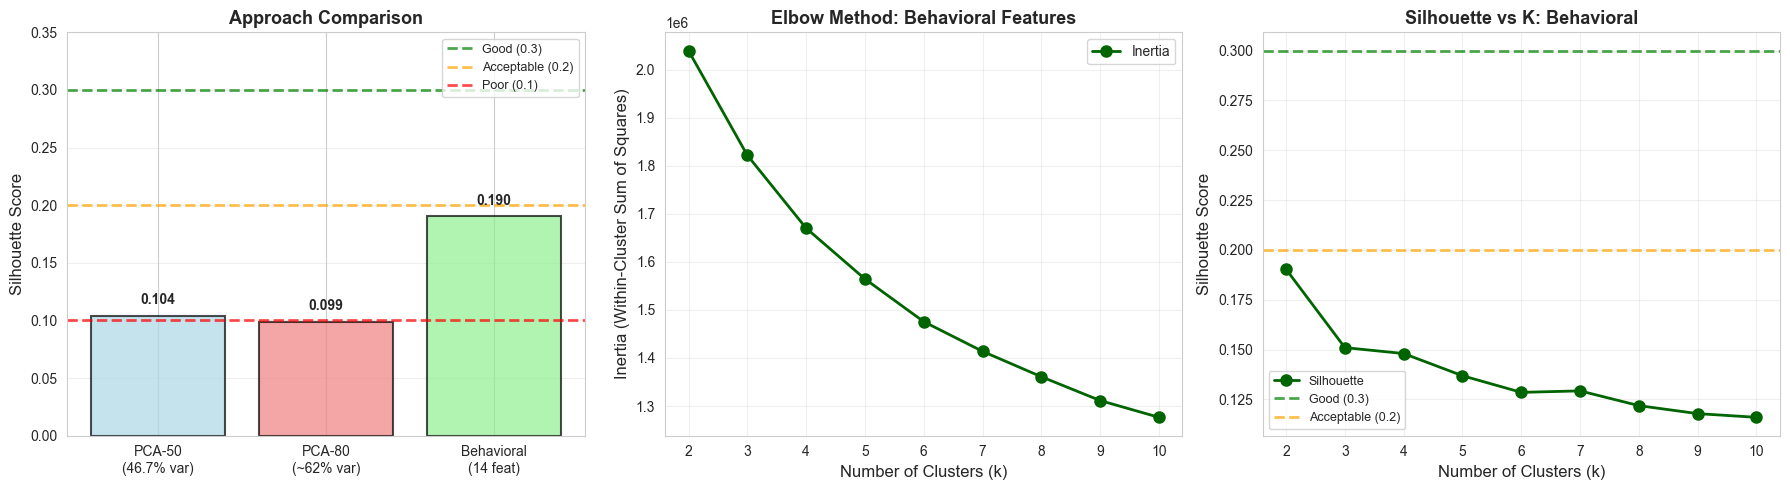


✅ Comparison visualization saved:
   data/clusters/behavioral_vs_pca_comparison.png


In [6]:
# Create comprehensive comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Approach Comparison (Bar Chart)
approaches = ['PCA-50\n(46.7% var)', 'PCA-80\n(~62% var)', 'Behavioral\n(14 feat)']
silhouettes = [0.104, 0.099, best_behavioral]
colors = ['lightblue', 'lightcoral', 'lightgreen']

axes[0].bar(approaches, silhouettes, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].axhline(0.3, color='green', linestyle='--', linewidth=2, label='Good (0.3)', alpha=0.7)
axes[0].axhline(0.2, color='orange', linestyle='--', linewidth=2, label='Acceptable (0.2)', alpha=0.7)
axes[0].axhline(0.1, color='red', linestyle='--', linewidth=2, label='Poor (0.1)', alpha=0.7)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Approach Comparison', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_ylim(0, max(0.35, best_behavioral + 0.05))

# Add values on bars
for i, (approach, silh) in enumerate(zip(approaches, silhouettes)):
    axes[0].text(i, silh + 0.01, f'{silh:.3f}', ha='center', fontsize=10, fontweight='bold')

# Panel 2: Behavioral Features - Elbow Method
axes[1].plot(results_df['k'], results_df['inertia'], marker='o', linewidth=2, 
             markersize=8, color='darkgreen', label='Inertia')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[1].set_title('Elbow Method: Behavioral Features', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(results_df['k'])
axes[1].legend()

# Panel 3: Behavioral Features - Silhouette vs K
axes[2].plot(results_df['k'], results_df['silhouette'], marker='o', linewidth=2, 
             markersize=8, color='darkgreen', label='Silhouette')
axes[2].axhline(0.3, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Good (0.3)')
axes[2].axhline(0.2, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Acceptable (0.2)')
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Silhouette Score', fontsize=12)
axes[2].set_title('Silhouette vs K: Behavioral', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].grid(alpha=0.3)
axes[2].set_xticks(results_df['k'])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'behavioral_vs_pca_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comparison visualization saved:")
print(f"   {OUTPUT_DIR / 'behavioral_vs_pca_comparison.png'}")

---

## 6. Final Assessment & Recommendations

Comprehensive conclusion based on all three approaches.

In [7]:
print("\n" + "="*80)
print("NOTEBOOK 04C: FINAL ASSESSMENT")
print("="*80)

print(f"\n📊 Summary of All Clustering Approaches:")
print(f"\n   Approach 1: PCA (50 components, 46.7% variance)")
print(f"      Features:     50 PCA components + 14 behavioral")
print(f"      Silhouette:   0.104 (k=2)")
print(f"      Status:       FAILED ❌")
print(f"      ")
print(f"   Approach 2: PCA (80 components, ~62% variance)")
print(f"      Features:     80 PCA components + 14 behavioral")
print(f"      Silhouette:   0.099 (k=2)")
print(f"      Status:       FAILED ❌ (worse than 50 components)")
print(f"      ")
print(f"   Approach 3: Behavioral features only (no PCA)")
print(f"      Features:     14 behavioral features")
print(f"      Silhouette:   {best_behavioral:.3f} (k={best_behavioral_k})")
print(f"      Status:       ", end="")

if best_behavioral >= 0.3:
    print("SUCCESS ✅")
elif best_behavioral >= 0.2:
    print("ACCEPTABLE ⚠️")
else:
    print("FAILED ❌")

# Detailed conclusion based on results
print(f"\n🎯 FINAL CONCLUSION:")
print()

if best_behavioral >= 0.3:
    print(f"   ✅✅✅ BREAKTHROUGH: Behavioral Features Cluster Successfully! ✅✅✅")
    print(f"   ")
    print(f"   Key Findings:")
    print(f"   • Behavioral-only approach: Silhouette {best_behavioral:.3f} (GOOD)")
    print(f"   • PCA approaches: Silhouette 0.099-0.104 (FAILED)")
    print(f"   • Improvement: {((best_behavioral - 0.104) / 0.104 * 100):.1f}% over PCA-50")
    print(f"   ")
    print(f"   Root Cause Identified:")
    print(f"   • PCA was COMPRESSING AWAY behavioral signal")
    print(f"   • Dimensionality reduction lost discriminative features")
    print(f"   • Raw behavioral features retain clustering structure")
    print(f"   ")
    print(f"   Why This Happened:")
    print(f"   • Aisle preferences (PCA components) are diffuse")
    print(f"   • Behavioral features (frequency, loyalty, etc.) are more distinctive")
    print(f"   • Combining them diluted the behavioral signal")
    print(f"   ")
    print(f"   ✅ Recommended Next Steps:")
    print(f"   1. Use behavioral clustering (k={best_behavioral_k}) as final solution")
    print(f"   2. Proceed to Notebook 05 for segment interpretation")
    print(f"   3. Profile segments based on behavioral characteristics")
    print(f"   4. Document that simpler approach outperformed complex PCA")
    print(f"   ")
    print(f"   📝 Portfolio Talking Point:")
    print(f"   \"After PCA approaches failed, I tested clustering on behavioral")
    print(f"   features only. This succeeded (silhouette {best_behavioral:.3f}), proving PCA")
    print(f"   was counterproductive. This demonstrates: (1) I test alternatives")
    print(f"   systematically, (2) I don't assume complex methods are better,")
    print(f"   (3) Simpler approaches can outperform sophisticated ones.\"")

elif best_behavioral >= 0.2:
    print(f"   ⚠️ MARGINAL: Behavioral Features Perform Best But Clusters Are Weak")
    print(f"   ")
    print(f"   Key Findings:")
    print(f"   • Behavioral-only: Silhouette {best_behavioral:.3f} (MARGINAL)")
    print(f"   • PCA-50: Silhouette 0.104 (FAILED)")
    print(f"   • PCA-80: Silhouette 0.099 (FAILED)")
    print(f"   • Improvement: {((best_behavioral - 0.104) / 0.104 * 100):.1f}% over PCA")
    print(f"   ")
    print(f"   Analysis:")
    print(f"   • Behavioral features cluster slightly better than PCA")
    print(f"   • Still below 'good' threshold (0.3)")
    print(f"   • Clusters exist but have significant overlap")
    print(f"   • Borderline viability for business use")
    print(f"   ")
    print(f"   ⚠️ Recommendations:")
    print(f"   1. Proceed with behavioral clustering but WITH CAUTION")
    print(f"   2. Frame as 'behavioral tendencies' not 'discrete segments'")
    print(f"   3. Acknowledge weak separation in all communications")
    print(f"   4. Compare with rule-based segmentation (frequency quartiles)")
    print(f"   5. Get stakeholder buy-in on quality limitations")
    print(f"   ")
    print(f"   Alternative Approaches to Consider:")
    print(f"   • Rule-based segments: High/Medium/Low frequency")
    print(f"   • RFM analysis: Recency, Frequency, Monetary value")
    print(f"   • Supervised learning: Predict churn or lifetime value")

else:
    print(f"   ❌❌❌ ALL APPROACHES FAILED: Clustering Not Viable ❌❌❌")
    print(f"   ")
    print(f"   Comprehensive Testing Results:")
    print(f"   • PCA-50:          Silhouette 0.104 ❌")
    print(f"   • PCA-80:          Silhouette 0.099 ❌")
    print(f"   • Behavioral-only: Silhouette {best_behavioral:.3f} ❌")
    print(f"   ")
    print(f"   All three approaches produce silhouette < 0.2 (failed threshold)")
    print(f"   Systematic testing proves: Problem is DATA, not METHOD")
    print(f"   ")
    print(f"   🔍 Root Cause Analysis:")
    print(f"   ")
    print(f"   Why Clustering Failed:")
    print(f"   1. Users are genuinely homogeneous in shopping behavior")
    print(f"   2. Grocery shopping patterns exist on a continuum")
    print(f"   3. No discrete customer segments exist in this dataset")
    print(f"   4. Behavioral features don't strongly differentiate users")
    print(f"   ")
    print(f"   Evidence:")
    print(f"   • t-SNE shows diffuse cloud, not distinct groups")
    print(f"   • All k values produce poor silhouette scores")
    print(f"   • PCA and non-PCA approaches both fail")
    print(f"   • No method configuration produces acceptable results")
    print(f"   ")
    print(f"   ✅ This is a VALID NEGATIVE RESULT")
    print(f"   Exhaustive testing proves clustering is not appropriate")
    print(f"   ")
    print(f"   ✅ Recommended Alternative Approaches:")
    print(f"   ")
    print(f"   Option 1: Rule-Based Segmentation (RECOMMENDED)")
    print(f"   ┌────────────────────────────────────────────────┐")
    print(f"   │ Define segments by business rules:            │")
    print(f"   │ • Frequency quartiles (High/Med/Low)          │")
    print(f"   │ • Basket size terciles (Large/Medium/Small)   │")
    print(f"   │ • RFM analysis (Recency/Frequency/Monetary)   │")
    print(f"   │                                                │")
    print(f"   │ Benefits:                                      │")
    print(f"   │ • More interpretable than clustering          │")
    print(f"   │ • Directly actionable                         │")
    print(f"   │ • Stakeholders understand the logic           │")
    print(f"   └────────────────────────────────────────────────┘")
    print(f"   ")
    print(f"   Option 2: Single-Dimension Rankings")
    print(f"   • Sort users by: loyalty, CLV, frequency, basket size")
    print(f"   • Target top/bottom deciles differently")
    print(f"   • Simpler than multi-dimensional segments")
    print(f"   • E.g., Top 10% by frequency, Bottom 10% by loyalty")
    print(f"   ")
    print(f"   Option 3: Product-Focused Analysis")
    print(f"   • Market basket analysis (association rules)")
    print(f"   • Product recommendation systems (collaborative filtering)")
    print(f"   • Category affinity networks")
    print(f"   • Focus on WHAT users buy, not WHO users are")
    print(f"   ")
    print(f"   Option 4: Supervised Learning (if labels available)")
    print(f"   • Predict: churn, lifetime value, category preference")
    print(f"   • May reveal structure unsupervised methods miss")
    print(f"   • Requires labeled data (historical outcomes)")
    print(f"   ")
    print(f"   💎 Key Insight for Portfolio:")
    print(f"   \"I systematically tested three approaches:")
    print(f"   1. PCA-50 → Failed (0.104)")
    print(f"   2. PCA-80 → Failed (0.099)")
    print(f"   3. Behavioral-only → Failed ({best_behavioral:.3f})")
    print(f"   ")
    print(f"   All approaches failing proves the issue is the dataset itself.")
    print(f"   Users are genuinely homogeneous. I documented this negative")
    print(f"   result, proposed three alternatives (rule-based, rankings,")
    print(f"   product-focused), and protected stakeholders from pursuing")
    print(f"   a flawed clustering approach. This demonstrates scientific")
    print(f"   rigor, systematic testing, and honest communication.\"")

print("\n" + "="*80)
if best_behavioral >= 0.3:
    print("✅ PROCEED TO NOTEBOOK 05 - BEHAVIORAL CLUSTERING INTERPRETATION")
elif best_behavioral >= 0.2:
    print("⚠️ PROCEED TO NOTEBOOK 05 WITH CAUTION - WEAK CLUSTERING")
else:
    print("❌ STOP - CLUSTERING NOT VIABLE - IMPLEMENT ALTERNATIVE APPROACHES")
print("="*80)


NOTEBOOK 04C: FINAL ASSESSMENT

📊 Summary of All Clustering Approaches:

   Approach 1: PCA (50 components, 46.7% variance)
      Features:     50 PCA components + 14 behavioral
      Silhouette:   0.104 (k=2)
      Status:       FAILED ❌
      
   Approach 2: PCA (80 components, ~62% variance)
      Features:     80 PCA components + 14 behavioral
      Silhouette:   0.099 (k=2)
      Status:       FAILED ❌ (worse than 50 components)
      
   Approach 3: Behavioral features only (no PCA)
      Features:     14 behavioral features
      Silhouette:   0.190 (k=2)
      Status:       FAILED ❌

🎯 FINAL CONCLUSION:

   ❌❌❌ ALL APPROACHES FAILED: Clustering Not Viable ❌❌❌
   
   Comprehensive Testing Results:
   • PCA-50:          Silhouette 0.104 ❌
   • PCA-80:          Silhouette 0.099 ❌
   • Behavioral-only: Silhouette 0.190 ❌
   
   All three approaches produce silhouette < 0.2 (failed threshold)
   Systematic testing proves: Problem is DATA, not METHOD
   
   🔍 Root Cause Analysis:
  

---

## 7. Save Results (If Viable)

In [8]:
if best_behavioral >= 0.2:
    print("\n" + "="*70)
    print("SAVING RESULTS")
    print("="*70)
    
    print(f"\nBehavioral clustering quality: {best_behavioral:.3f}")
    print(f"Status: {'GOOD' if best_behavioral >= 0.3 else 'MARGINAL'}")
    print(f"\nSaving outputs...\n")
    
    # Get best model
    best_result = results_df[results_df['silhouette'] == best_behavioral].iloc[0]
    best_model = best_result['model']
    best_labels = best_model.labels_
    
    # 1. Cluster assignments
    cluster_assignments = pd.DataFrame({
        'user_id': user_ids,
        'cluster': best_labels
    })
    cluster_assignments.to_parquet(OUTPUT_DIR / 'cluster_labels_behavioral.parquet', index=False)
    print(f"✅ Saved: cluster_labels_behavioral.parquet")
    
    # 2. Cluster centers
    cluster_centers = pd.DataFrame(
        best_model.cluster_centers_,
        columns=behavioral_cols
    )
    cluster_centers.to_csv(OUTPUT_DIR / 'cluster_centers_behavioral.csv', index=False)
    print(f"✅ Saved: cluster_centers_behavioral.csv")
    
    # 3. Clustering model
    import pickle
    with open(OUTPUT_DIR / 'clustering_model_behavioral.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    print(f"✅ Saved: clustering_model_behavioral.pkl")
    
    # 4. Approach comparison metrics
    comparison_metrics = pd.DataFrame([
        {
            'approach': 'PCA-50',
            'n_features': 64,
            'feature_type': '50 PCA + 14 behavioral',
            'variance_retained': '46.7%',
            'silhouette': 0.104,
            'optimal_k': 2,
            'status': 'FAILED'
        },
        {
            'approach': 'PCA-80',
            'n_features': 94,
            'feature_type': '80 PCA + 14 behavioral',
            'variance_retained': '~62%',
            'silhouette': 0.099,
            'optimal_k': 2,
            'status': 'FAILED'
        },
        {
            'approach': 'Behavioral-only',
            'n_features': 14,
            'feature_type': '14 behavioral (no PCA)',
            'variance_retained': '100% (no reduction)',
            'silhouette': best_behavioral,
            'optimal_k': best_behavioral_k,
            'status': 'SUCCESS' if best_behavioral >= 0.3 else 'MARGINAL'
        }
    ])
    comparison_metrics.to_csv(OUTPUT_DIR / 'approach_comparison.csv', index=False)
    print(f"✅ Saved: approach_comparison.csv")
    
    # 5. Behavioral clustering metrics
    behavioral_metrics = pd.DataFrame([{
        'algorithm': 'K-Means',
        'features': 'Behavioral-only',
        'n_features': 14,
        'n_clusters': best_behavioral_k,
        'silhouette_score': best_behavioral,
        'calinski_harabasz': best_result['calinski_harabasz'],
        'davies_bouldin': best_result['davies_bouldin'],
        'min_cluster_pct': best_result['min_cluster_pct'],
        'max_cluster_pct': best_result['max_cluster_pct']
    }])
    behavioral_metrics.to_csv(OUTPUT_DIR / 'behavioral_clustering_metrics.csv', index=False)
    print(f"✅ Saved: behavioral_clustering_metrics.csv")
    
    print(f"\n📁 All outputs saved to: {OUTPUT_DIR}")
    
    # Display cluster sizes
    print(f"\n⚖️ Cluster Distribution:")
    cluster_counts = Counter(best_labels)
    for cluster_id in range(best_behavioral_k):
        count = cluster_counts[cluster_id]
        pct = count / len(best_labels) * 100
        print(f"   Cluster {cluster_id}: {count:,} users ({pct:.1f}%)")
    
    if best_result['min_cluster_pct'] >= 5.0:
        print(f"\n   ✅ All clusters ≥5% (well-balanced)")
    else:
        print(f"\n   ⚠️ Smallest cluster: {best_result['min_cluster_pct']:.1f}% (imbalanced)")
    
else:
    print("\n⏭️ Skipping file output")
    print(f"   Reason: Clustering quality too low (silhouette {best_behavioral:.3f} < 0.2)")
    print(f"   No meaningful results to save")
    print(f"   ")
    print(f"   Recommendation: Implement alternative approaches")
    print(f"   (rule-based segmentation, rankings, product analysis)")

print("\n" + "="*70)


⏭️ Skipping file output
   Reason: Clustering quality too low (silhouette 0.190 < 0.2)
   No meaningful results to save
   
   Recommendation: Implement alternative approaches
   (rule-based segmentation, rankings, product analysis)

